In [2]:
import pywt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Using TensorFlow backend.


In [3]:
Data = pd.read_csv('AMZN.csv', header=0, usecols=['Date', 'Close'], parse_dates=True, index_col='Date')
Data.index = pd.to_datetime(Data.index)

In [8]:
display(Data.head())
display(Data.describe())

,Close
Date,
2000-06-05,54.5000
2000-06-06,50.5625
2000-06-07,51.8125
2000-06-08,51.8750
2000-06-09,52.1875


,Close
count,4529.000000
mean,243.952496
std,323.696425
min,5.970000
25%,38.740002
50%,87.269997
75%,306.540009
max,1696.349976


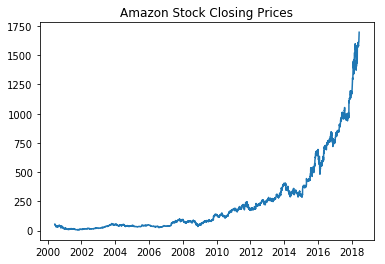

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4529 entries, 2000-06-05 to 2018-06-05
Data columns (total 1 columns):
Close    4529 non-null float64
dtypes: float64(1)
memory usage: 70.8 KB


None

In [7]:
plt.figure()
plt.title('Amazon Stock Closing Prices')
plt.plot(Data)
plt.show()

display(Data.info())

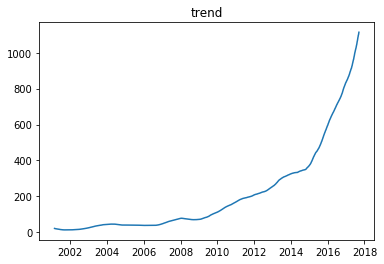

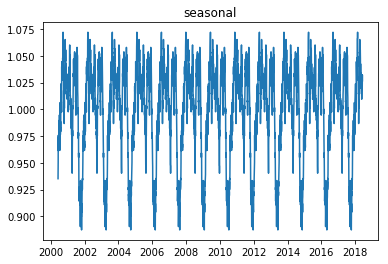

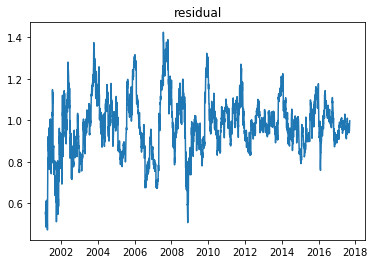

In [42]:
decomposition = seasonal_decompose(Data, 
                                   model='multiplicative', 
                                   freq=365)

plt.figure()
plt.title('trend')
plt.plot(decomposition.trend)
plt.show()

plt.figure()
plt.title('seasonal')
plt.plot(decomposition.seasonal)
plt.show()

plt.figure()
plt.title('residual')
plt.plot(decomposition.resid)
plt.show()

<Figure size 432x288 with 0 Axes>

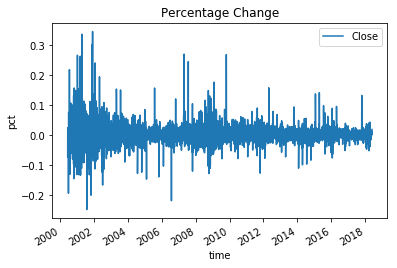

<Figure size 432x288 with 0 Axes>

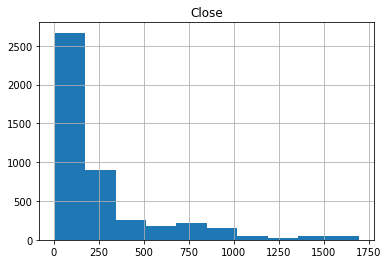

<Figure size 432x288 with 0 Axes>

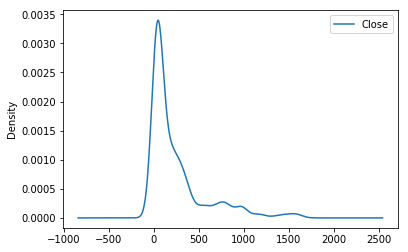

In [43]:
plt.figure()
Data.pct_change().plot()
plt.title('Percentage Change')
plt.xlabel('time')
plt.ylabel('pct')
plt.show()

plt.figure()
Data.hist()
plt.show()


plt.figure()
Data.plot(kind='kde')
plt.show()

Tain test split

$ \textbf{Y}(original series) = \textbf{Y}^{LINEAR} + \textbf{Y}^{NONLINEAR}$

$ N_{tr} :=$ size of training set

$ N_{ts} :=$ size of testing set

In [53]:
Y = Data['Close']

N = len(Y)
N_tr = int(N * 0.7)
N_ts = N - N_tr

Y_tr = Y[0:N_tr:]
Y_ts = Y[N_tr:N:]

In [66]:
Y_tr, lam = boxcox(Y_tr) # to stationarize, using a square power transformation
print('lambda: ', lam)

lambda:  0.030056471716460552


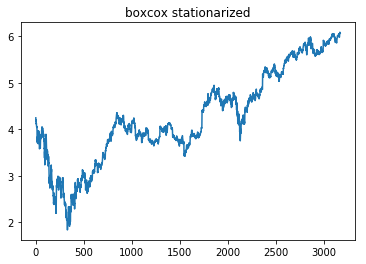

In [73]:
plt.figure()
plt.title('boxcox stationarized')
plt.plot(Y_tr)
plt.show()

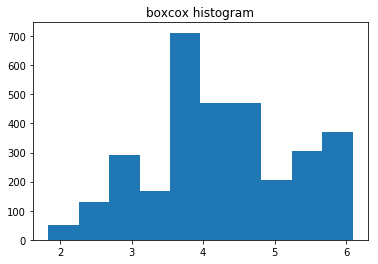

In [74]:
plt.figure
plt.title('boxcox histogram')
plt.hist(Y_tr)
plt.show()#seems to be just a log power

In [75]:
A, D = pywt.dwt(Y_tr, 'db1') #C is low frequency signal, D is high frequency signal
Y_tr_ap = pywt.idwt(A, None, 'db1')
Y_tr_ds = pywt.idwt(None, D, 'db1')

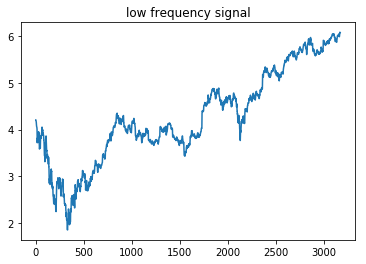

In [76]:
plt.title('low frequency signal')
plt.plot(Y_tr_ap)

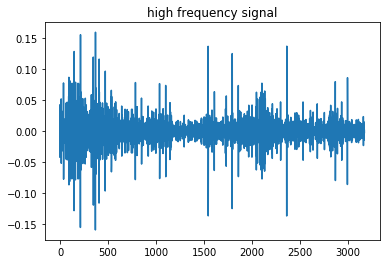

In [77]:
plt.title('high frequency signal')
plt.plot(Y_tr_ds)

The low frequency signal will be used with an RNN. The high frequency signal will be used with ARIMA.

high frequency


C:\Users\kalie\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


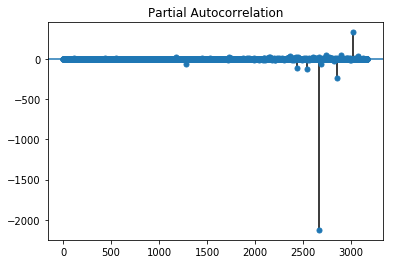

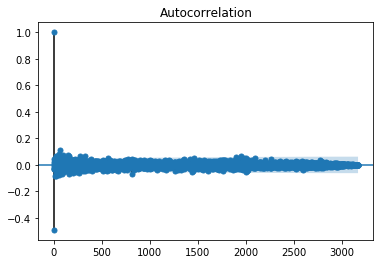

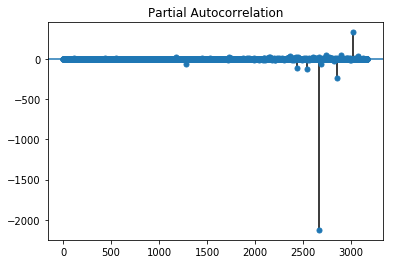

In [78]:
print('high frequency')
plot_acf(Y_tr_ds)
plot_pacf(Y_tr_ds)

Next is to perform an auto ARIMA on both low and high frequency signals. Aftwerwards, take the residuals of both and train on them with an ANN

In [ ]:
arma_tr = auto_arima(Y_tr_ds, error_action='ignore', trace=1, seasonal=True, stationary=True, m=7, max_p=10, max_q=10)
print(arima_tr.aic())

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 7); AIC=-17580.047, BIC=-17531.555, Fit time=7.891 seconds


C:\Users\kalie\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 7); AIC=-15511.065, BIC=-15498.942, Fit time=0.298 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 7); AIC=-16378.277, BIC=-16354.031, Fit time=0.282 seconds


C:\Users\kalie\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kalie\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 7); AIC=-17688.498, BIC=-17664.252, Fit time=4.287 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 7); AIC=-17686.199, BIC=-17655.892, Fit time=5.046 seconds


C:\Users\kalie\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kalie\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 7); AIC=-17693.253, BIC=-17675.068, Fit time=3.630 seconds


C:\Users\kalie\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 7); AIC=-17688.859, BIC=-17664.613, Fit time=6.145 seconds


C:\Users\kalie\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
